# Mounting G-Drive
We mount the google drive to fetch the required files to be processed.

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My Drive/project
!pwd

[Errno 2] No such file or directory: 'drive/My Drive/project'
/content/drive/My Drive/project
/content/drive/My Drive/project


In [ ]:
!pip install SimpleITK

# Importing Libraries

In [ ]:
import SimpleITK as sitk
from SimpleITK.extra import GetArrayViewFromImage
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Reading Images

In [ ]:
ct_fixed1=sitk.ReadImage("ct.nii.gz")
mr_moving1=sitk.ReadImage("mr.nii.gz")

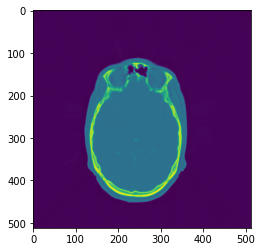

In [ ]:
slice=sitk.GetArrayViewFromImage(ct_fixed)[10,:,:]
plt.imshow(slice)

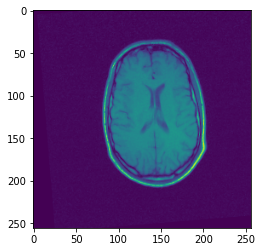

In [ ]:
slice1=sitk.GetArrayViewFromImage(mr_moving)[10,:,:]
plt.imshow(slice1)

# Defining functions for displaying interactive images

In [ ]:
# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')

    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')

    plt.show()
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()

# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
  global metric_values, multires_iterations
  multires_iterations.append(len(metric_values))

In [ ]:
ct_fixed =  sitk.ReadImage("ct.mha", sitk.sitkFloat32)
mr_moving = sitk.ReadImage("mr.mha", sitk.sitkFloat32)

interact(display_images, fixed_image_z=(0,ct_fixed.GetSize()[2]-1), moving_image_z=(0,mr_moving.GetSize()[2]-1),
         fixed_npa = fixed(sitk.GetArrayViewFromImage(ct_fixed)), moving_npa=fixed(sitk.GetArrayViewFromImage(mr_moving)));

interactive(children=(IntSlider(value=14, description='fixed_image_z', max=28), IntSlider(value=12, descriptio…

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(ct_fixed,mr_moving,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(mr_moving, ct_fixed, initial_transform, sitk.sitkLinear, 0.0, mr_moving.GetPixelID())

interact(display_images_with_alpha, image_z=(0,ct_fixed.GetSize()[2]-1),
         alpha=(0.0,1.0,0.05), fixed = fixed(ct_fixed), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=14, description='image_z', max=28), FloatSlider(value=0.5, description='…

# Image Registration

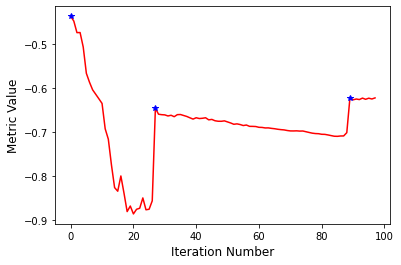

In [ ]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(ct_fixed, sitk.sitkFloat32),
                                               sitk.Cast(mr_moving, sitk.sitkFloat32))

In [ ]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.6239415547696892
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [ ]:
mr_moving_resampled = sitk.Resample(mr_moving, ct_fixed, final_transform, sitk.sitkLinear, 0.0, mr_moving.GetPixelID())

interact(display_images_with_alpha, image_z=(0,ct_fixed.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(ct_fixed), moving=fixed(mr_moving_resampled));



interactive(children=(IntSlider(value=14, description='image_z', max=28), FloatSlider(value=0.5, description='…

In [ ]:
sitk.WriteImage(mr_moving_resampled,'/content/drive/My Drive/project/mr_resampled.mha')
sitk.WriteTransform(final_transform, '/content/drive/My Drive/project/mr_resampled.tfm')

#Histogram of Images

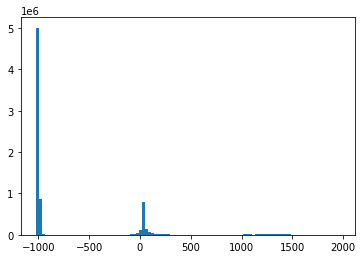

In [ ]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(ct_fixed).flatten(), bins=100)
plt.show()

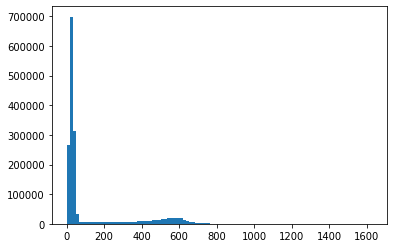

In [ ]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(mr_moving).flatten(), bins=100)
plt.show()

#Using Threshold: Brain Extraction
Since it wasnt possible for me to install fslbet function on google colab, I am trying to make a filter/ mask for brain extraction from the given images.

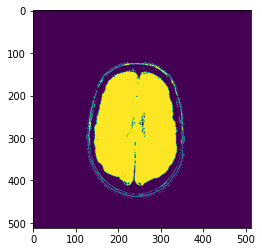

In [ ]:
seg = (ct_fixed> 5)&(ct_fixed<60)

z=17
slice=sitk.GetArrayViewFromImage(seg)[z,:,:]
plt.imshow(slice)

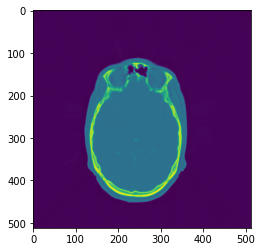

In [ ]:
z=10
slice=sitk.GetArrayViewFromImage(ct_fixed)[z,:,:]
plt.imshow(slice)

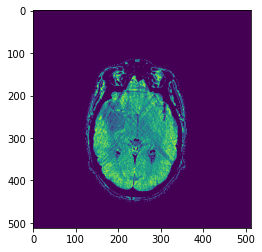

In [ ]:
desired_brain_ct=sitk.Threshold 	(ct_fixed, lower = 5,upper = 60,outsideValue = 0.0 )
z=10
slice=sitk.GetArrayViewFromImage(desired_brain_ct)[z,:,:]
plt.imshow(slice)

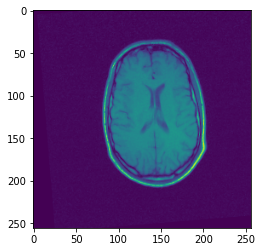

In [ ]:
z=10
slice=sitk.GetArrayViewFromImage(mr_moving)[z,:,:]
plt.imshow(slice)

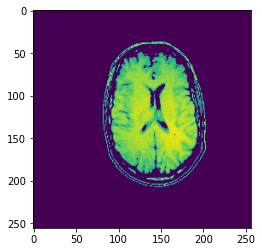

In [ ]:
desired_brain_mr=sitk.Threshold(mr_moving, lower = 400,upper = 700,outsideValue = 0.0 )
z=10
slice=sitk.GetArrayViewFromImage(desired_brain_mr)[z,:,:]
plt.imshow(slice)

#References
[1]  http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html

[2]  https://simpleitk.org/doxygen/latest/html/namespaceitk_1_1simple.html#a4441b751c680531cd91dc7eb329573e1
